In [1]:
import numpy as np
from skimage.transform import resize
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, ConvLSTM2D, TimeDistributed
from sklearn.externals import joblib
import pylidc as pl

import matplotlib.pyplot as plt
%matplotlib inline

/Users/amandazhang/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
image_size = (256, 256)
num_slices = 50

In [3]:
unet = load_model('unet.hdf5')

In [4]:
scans = pl.query(pl.Scan)
n = scans.count()

In [5]:
test = joblib.load('test_set.p')
train = list(set(range(n)) - set(test))

In [6]:
def get_data(i):
    scan = scans[i]
    images = scan.load_all_dicom_images(verbose=False)
    n = len(images)
    X = np.array([resize(im.pixel_array, image_size, mode='constant') for im in images])
    X = np.expand_dims(X, axis=-1)
    y = np.zeros((512, 512, n))
    for ann in scan.annotations:
        b = ann.bbox()
        y[b] = np.logical_or(y[b], ann.boolean_mask())
    y = np.rollaxis(y, 2, 0)
    y = resize(y, (n, *image_size), mode='constant')
    y = np.expand_dims(y, axis=-1)
    start = np.random.randint(n - num_slices)
    X = X[start:start + num_slices]
    y = y[start:start + num_slices]
    return unet.predict(X, batch_size=1)[None], y[None]

In [34]:
X, y = get_data(0)

/Users/amandazhang/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 50 + 1) instead
  app.launch_new_instance()


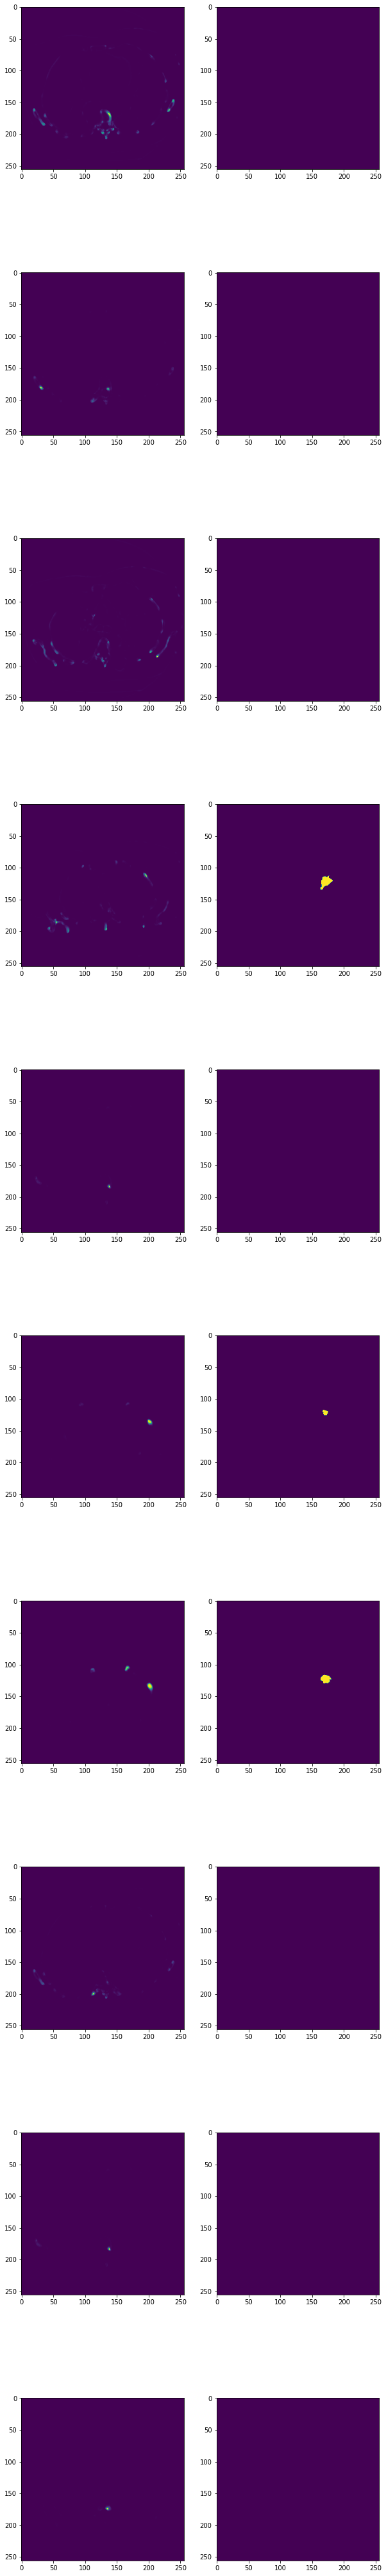

In [44]:
fig, ax = plt.subplots(10,2, figsize = (10,15*5))
for x in range(ax.shape[0]):
    z_slice = np.random.random_integers(0,high=X.shape[1])
    ax[x,0].imshow(X[0,z_slice,:,:,0]) 
    ax[x,1].imshow(y[0,z_slice,:,:,0]) 

In [33]:
y

1

In [36]:
y.shape

(1, 50, 256, 256, 1)